In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import bayes3d as b
import time
from PIL import Image
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import cv2
import trimesh
import os
import glob
import bayes3d.neural
import pickle
import genjax

In [2]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=150.0, fy=150.0,
    cx=50.0, cy=50.0,
    near=0.001, far=6.0
)
b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(13+1).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(10+1).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [3]:
b.RENDERER.model_box_dims

Array([[1.16966e-01, 9.30750e-02, 8.13840e-02],
       [1.48997e-01, 1.44769e-01, 2.42640e-01],
       [1.00000e-09, 1.00000e-09, 1.00000e-09]], dtype=float32)

In [4]:
importance_jit = jax.jit(b.model.importance)
key = jax.random.PRNGKey(10)

In [5]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [6]:
def viz_trace_meshcat(trace, colors=None):
    b.clear_visualizer()
    b.show_cloud("1", b.apply_transform_jit(trace["image"].reshape(-1,3), trace["camera_pose"]))
    b.show_cloud("2", b.apply_transform_jit(b.get_rendered_image(trace).reshape(-1,3), trace["camera_pose"]),color=b.RED)
    indices = trace.get_retval()[1]
    if colors is None:
        colors = b.viz.distinct_colors(max(10, len(indices)))
    for i in range(len(indices)):
        b.show_trimesh(f"obj_{i}", b.RENDERER.meshes[indices[i]],color=colors[i])
        b.set_pose(f"obj_{i}", trace.get_retval()[2][i])
    b.show_pose(f"camera_pose", trace["camera_pose"])


43.175415


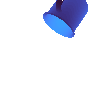

In [49]:
key = jax.random.split(key)[0]
weight, trace = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "id_0": jnp.int32(0),
    "camera_pose": jnp.eye(4),
    # # "root_pose_0": b.transform_from_pos(jnp.array([0.0, 0.0, 0.4])),
    "variance": 0.02,
    "outlier_prob": 0.0001,
}), (
    jnp.arange(1),
    jnp.arange(3),
    jnp.array([jnp.array([-0.1,-0.1,-0.1]), jnp.array([0.1,0.1,0.4])]),
    jnp.array([jnp.array([-12.0, -12.0, -22*jnp.pi]), jnp.array([12.0, 12.0, 22*jnp.pi])]),
    b.RENDERER.model_box_dims)
)
viz_trace_meshcat(trace)
print(trace.get_score())
obs_image = trace["image"]
b.get_depth_image(obs_image, max_val=0.8)

In [55]:
key = jax.random.split(key)[0]
def importance_sample(key):
    weight, trace = importance_jit(key, genjax.choice_map({
        "parent_0": -1,
        "id_0": jnp.int32(0),
        "camera_pose": jnp.eye(4),
        # "root_pose_0": b.transform_from_pos(jnp.array([0.0, 0.0, 0.4])),
        "variance": 0.02,
        "outlier_prob": 0.0001,
        "image": obs_image
    }), (
        jnp.arange(1),
        jnp.arange(3),
        jnp.array([jnp.array([-0.1,-0.1,-0.1]), jnp.array([0.1,0.1,0.4])]),
        jnp.array([jnp.array([-12.0, -12.0, -22*jnp.pi]), jnp.array([12.0, 12.0, 22*jnp.pi])]),
        b.RENDERER.model_box_dims)
    )
    return trace["root_pose_0"], trace.get_score()

importance_sample_vmap = jax.jit(jax.vmap(importance_sample, in_axes=(0)))

38.260414
38.255413


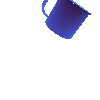

In [59]:
key = jax.random.split(key)[0]
poses, weights = importance_sample_vmap(jax.random.split(key, 5000))
print(weights.max())
weight, trace = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "id_0": jnp.int32(0),
    "camera_pose": jnp.eye(4),
    "root_pose_0": poses[weights.argmax()],
    "variance": 0.02,
    "outlier_prob": 0.0001,
    "image": obs_image
}), (
    jnp.arange(1),
    jnp.arange(3),
    jnp.array([jnp.array([-0.1,-0.1,-0.1]), jnp.array([0.1,0.1,0.4])]),
    jnp.array([jnp.array([-12.0, -12.0, -22*jnp.pi]), jnp.array([12.0, 12.0, 22*jnp.pi])]),
    b.RENDERER.model_box_dims)
)
viz_trace_meshcat(trace)
print(trace.get_score())
b.get_depth_image(b.get_rendered_image(trace), max_val=0.8)